In [ ]:
from processing.preprocessing import BCIDataProcessor
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_predict, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (classification_report, confusion_matrix, ConfusionMatrixDisplay,
                             accuracy_score, precision_score, recall_score, f1_score)
from scipy.stats import randint


recording_path = '../recordings/recording_imagery1_gel.raw.fif'
window_size = 2
window_overlap = 1
processor = BCIDataProcessor(recording_path, l_freq=7, h_freq=30, window_size=window_size,
                             window_overlap=window_overlap)
data = processor.process(psds=True, nfft=500)
# Only select left_hand and right_hand
data = {label: data[label] for label in data.keys() if label in ['relax', 'focus']}
data

In [6]:
X = np.concatenate(list(data.values()), axis=0)
X = X.reshape(X.shape[0], -1)  # Reshape to (samples, channels * features)
y = np.concatenate([[label] * data[label].shape[0] for label in data.keys()])  # (samples,)
X_trainval, X_test, y_trainval, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [7]:
X.shape, y.shape, X_trainval.shape, y_trainval.shape, X_test.shape, y_test.shape

((112, 376), (112,), (89, 376), (89,), (23, 376), (23,))

Best parameters found:  {'svc__C': np.float64(2.40893825622149), 'svc__degree': 4, 'svc__gamma': np.float64(0.001), 'svc__kernel': 'sigmoid'}
Training accuracy (CV avg):  0.8209150326797385
Accuracy: 0.7391
Precision (weighted): 0.7754
Recall (weighted): 0.7391
F1 Score (weighted): 0.7331


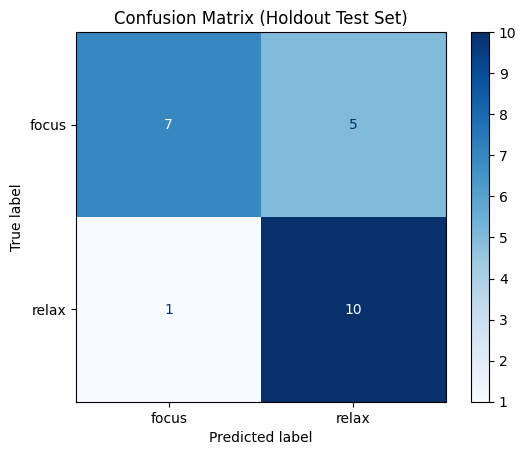

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import (classification_report, confusion_matrix, ConfusionMatrixDisplay,
                             accuracy_score, precision_score, recall_score, f1_score)
from scipy.stats import uniform

model = Pipeline([
    ('scaler', StandardScaler()),
    ('svc', SVC(random_state=42))
])

param_dist = {
    'svc__C': uniform(0.1, 10),          # Regularization strength
    'svc__gamma': ['scale', 'auto'] + list(np.logspace(-4, 1, 6)),  # Kernel coefficient
    'svc__kernel': ['rbf', 'poly', 'sigmoid'],  # Different kernel types
    'svc__degree': [2, 3, 4],            # Only relevant if kernel='poly'
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_dist,
    n_iter=30,
    cv=cv,
    scoring='accuracy',
    n_jobs=-1,
    random_state=42
)
random_search.fit(X_trainval, y_trainval)

best_model = random_search.best_estimator_
print("Best parameters found: ", random_search.best_params_)
print("Training accuracy (CV avg): ", random_search.best_score_)

y_pred = best_model.predict(X_test)

conf_matrix = confusion_matrix(y_test, y_pred)
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, average='weighted')
rec = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
report = classification_report(y_test, y_pred)

print(f"Accuracy: {acc:.4f}")
print(f"Precision (weighted): {prec:.4f}")
print(f"Recall (weighted): {rec:.4f}")
print(f"F1 Score (weighted): {f1:.4f}")

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=np.unique(y))
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix (Holdout Test Set)")
plt.show()